# 1. Libraries and Data Import

In [3]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import plot_partial_dependence

from fastai.tabular.all import *
from fastbook import *

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

from dtreeviz.trees import *

In [4]:
df = pd.read_csv('train.csv', low_memory=False, index_col='Id')
test_df = pd.read_csv('test.csv', low_memory=False, index_col='Id')

# 2. Data Pre-Processing 

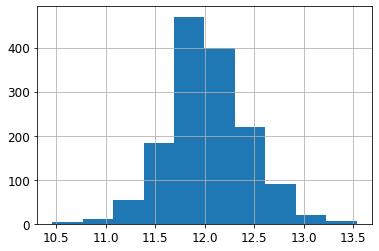

In [7]:
df['SalePrice'] = np.log(df['SalePrice'])
df['SalePrice'].hist()

In [8]:
def processing_pass1(df):
    qual_order = 'Po', 'Fa', 'TA', 'Gd', 'Ex'
    exp_order = 'No', 'Mn', 'Av', 'Gd'
    bsmt_finish_order = 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'
    garage_finish_order = 'Unf', 'RFn', 'Fin'

    df['BsmtExposure'] = df['BsmtExposure'].astype('category')
    df['BsmtExposure'].cat.set_categories(exp_order, ordered=True, inplace=True)

    df['BsmtFinType1'] = df['BsmtFinType1'].astype('category') 
    df['BsmtFinType1'].cat.set_categories(bsmt_finish_order, ordered=True, inplace=True)

    df['BsmtFinType2'] = df['BsmtFinType2'].astype('category') 
    df['BsmtFinType2'].cat.set_categories(bsmt_finish_order, ordered=True, inplace=True)

    df['GarageFinish'] = df['GarageFinish'].astype('category')
    df['GarageFinish'].cat.set_categories(garage_finish_order, ordered=True, inplace=True)

    df['LotShape'] = df['LotShape'].astype('category')
    df['LotShape'].cat.set_categories(['IR1','IR2','IR3'], ordered=True, inplace=True)

    df['LandSlope'] = df['LandSlope'].astype('category')
    df['LandSlope'].cat.set_categories(['Gtl','Mod','Sev'], ordered=True, inplace=True)

    df['Fence'] = df['Fence'].astype('category')
    df['Fence'].cat.set_categories(['MnWw','GdWo','MnPrv','GdPrv'], ordered=True, inplace=True)

    qual_var_list = ['ExterQual','ExterCond','BsmtQual','BsmtCond','KitchenQual','HeatingQC','FireplaceQu',
                     'GarageQual','GarageCond','PoolQC']
    for var in qual_var_list:
        df[var] = df[var].astype('category')
        df[var].cat.set_categories(qual_order, ordered=True, inplace=True)  

    #Missing treatment
    #Creating features based on high missing vars, and will drop the actual var post this
    df['PoolFlag'] = np.where(df['PoolQC'].isnull(),1,0)
    df['ElevatorFlag'] = np.where(df['MiscFeature']=='Elevator',1,0)
    df['TennisCourtFlag'] = np.where(df['MiscFeature']=='TenC',1,0)

    #GarageYrBuilt is missing for houses where there is no garage, 
    #hence it makes sense to replace is with 0 rather than using some other imputing strategy
    df.loc[df['GarageYrBlt'].isnull(),'GarageYrBlt'] = 0

    missing_vars = ['PoolQC','MiscFeature']
    df.drop(columns=missing_vars, inplace=True)
    
    return df

In [9]:
#Feature addition/changes post univariate/bivariate analysis
def processing_pass2(df):
    #Replacing LotFrontage & LotArea with logs
    df['LotFrontage'] = np.log(df['LotFrontage'])
    df['LotArea'] = np.log(df['LotArea'])
    
    #Very few values in garage cars >3 , hence volatile price
    df.loc[df['GarageCars']>3, 'GarageCars'] = 3
    
    #Seems like SalePrice has ordering as per MSZoning
    df['MSZoning'] = df['MSZoning'].astype('category')
    df['MSZoning'].cat.set_categories(['RM','FV','C (all)','RL','RH'], ordered=True, inplace=True)

    #Outlier capping post looking at the univariate/bivariate plots
    df.loc[df['BsmtFinSF1']>5000, 'BsmtFinSF1'] = 5000
    df.loc[df['TotalBsmtSF']>5000, 'TotalBsmtSF'] = 5000
    df.loc[df['1stFlrSF']>5000, '1stFlrSF'] = 5000
    df.loc[df['GrLivArea']>5000, 'GrLivArea'] = 5000

    df.loc[df['LotFrontage']>5.5, 'LotFrontage'] = 5.5
    df.loc[df['LotArea']>11.5, 'LotArea'] = 11.5
    
    #return df

In [10]:
df1 = processing_pass1(df.copy())
processing_pass2(df1)
cont, cat = cont_cat_split(df1, 1, dep_var='SalePrice')
splitter = RandomSplitter(seed=0)
procs = [Categorify, FillMissing]

In [30]:
to = TabularPandas(df1, procs, cat, cont, y_names='SalePrice')
xs, y = to.train.xs, to.train.y

In [19]:
to = TabularPandas(df1, procs, cat, cont, y_names='SalePrice', splits=splitter(df))
train_xs, train_y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y 

In [20]:
final_var_list = ['MSZoning', 'Neighborhood', 'CentralAir', 'FireplaceQu', 'GarageFinish', 'LotFrontage', 'LotArea', 
                  'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 
                  'GrLivArea', 'FullBath', 'GarageCars']

In [50]:
xs_final = xs#[final_var_list]
train_xs_final = train_xs#[final_var_list]
valid_xs_final = valid_xs#[final_var_list]

# 3. Model Evaluation & Hyperparameter Optimization

In [23]:
def rmse(y_true, y_pred):
    return round(np.sqrt(((y_true-y_pred)**2).mean()),6)

def m_rmse(m, xs, y):
    return rmse(y, m.predict(xs))

## 3.1 Linear Models

In [24]:
m1 = LinearRegression()
m1.fit(train_xs_final, train_y)

print('training rmse: ', m_rmse(m1, train_xs_final, train_y))
print('validation rmse: ', m_rmse(m1, valid_xs_final, valid_y))

training rmse:  0.134193
validation rmse:  0.179822


In [25]:
m1 = Lasso(normalize=True, alpha=.5)
m1.fit(train_xs_final, train_y)

print('training rmse: ', m_rmse(m1, train_xs_final, train_y))
print('validation rmse: ', m_rmse(m1, valid_xs_final, valid_y))

training rmse:  0.395159
validation rmse:  0.415614


In [26]:
m1 = Ridge(normalize=True, alpha=.6)
m1.fit(train_xs_final, train_y)

print('training rmse: ', m_rmse(m1, train_xs_final, train_y))
print('validation rmse: ', m_rmse(m1, valid_xs_final, valid_y))

training rmse:  0.147006
validation rmse:  0.174383


## 3.2 XGBoost

In [51]:
#get a sense of n_estimators at learning rate of .1
xgb1 = XGBRegressor(n_estimators=1000, random_state=0, learning_rate=.1)
xgb1.fit(train_xs_final, train_y, early_stopping_rounds=10, eval_set=[(valid_xs_final, valid_y)])

print('training rmse: ', m_rmse(xgb1, train_xs_final, train_y))
print('validation rmse: ', m_rmse(xgb1, valid_xs_final, valid_y))

[0]	validation_0-rmse:10.39685
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:9.36174
[2]	validation_0-rmse:8.43024
[3]	validation_0-rmse:7.58937
[4]	validation_0-rmse:6.83257
[5]	validation_0-rmse:6.15296
[6]	validation_0-rmse:5.53981
[7]	validation_0-rmse:4.98947
[8]	validation_0-rmse:4.49374
[9]	validation_0-rmse:4.04635
[10]	validation_0-rmse:3.64629
[11]	validation_0-rmse:3.28597
[12]	validation_0-rmse:2.96157
[13]	validation_0-rmse:2.66940
[14]	validation_0-rmse:2.40551
[15]	validation_0-rmse:2.16792
[16]	validation_0-rmse:1.95516
[17]	validation_0-rmse:1.76467
[18]	validation_0-rmse:1.59255
[19]	validation_0-rmse:1.43722
[20]	validation_0-rmse:1.29742
[21]	validation_0-rmse:1.17088
[22]	validation_0-rmse:1.05919
[23]	validation_0-rmse:0.95743
[24]	validation_0-rmse:0.86591
[25]	validation_0-rmse:0.78328
[26]	validation_0-rmse:0.70974
[27]	validation_0-rmse:0.64379
[28]	validation_0-rmse:0.58410
[29]	validation_0-rmse:0.53104
[30]	validatio

In [ ]:
# XGBoost with GridSearchCV

''' A parameter grid for XGBoost
params = {
        'n_estimators': [224],              #number of trees in the boosted model, default=100 (doubtful)
        'learning_rate': [.1],              #Makes the model robust by shrinking the weights on each step, default=0.3
        'max_depth': [4, 5, 6],             #maximum depth of a tree, default=6
        'min_child_weight': [1, 3, 5],      #minimum sum of weights of all observations required in a child, default=1
        'gamma': [0],                       #minimum loss reduction required to make a split, default=0
        'subsample': [0.8],                 #fraction of observations to be randomly samples for each tree, default=1
        'colsample_bytree': [0.8]           #fraction of columns to be randomly samples for each tree, default=1
        }
'''

In [53]:
# XGBoost with GridSearchCV
# Fix learning rate and n_estimators as above and optimize max_depth, min_child_weight
# If needed first pass could be run with higher range of values
params = {
        'max_depth': [5,6],             
        'min_child_weight': [2,3,4]      
        }

gs1 = GridSearchCV(estimator=XGBRegressor(nthread=8, random_state=0,
                                          n_estimators=96, learning_rate=0.1,
                                          max_depth=6, min_child_weight=5,
                                          gamma=0,
                                          subsample=0.8, colsample_bytree=0.8), 
                   param_grid=params, cv=5, scoring='neg_root_mean_squared_error')
gs1.fit(xs_final, df['SalePrice'])
gs1.best_params_, gs1.best_score_

({'max_depth': 5, 'min_child_weight': 3}, -0.12767209978674313)

In [55]:
# Fixing the tuned values and tuning gamma now
params = {
        'gamma': [0,0.005,0.007,0.01,0.01]     
        }

gs1 = GridSearchCV(estimator=XGBRegressor(nthread=8, random_state=0,
                                          n_estimators=96, learning_rate=0.1,
                                          max_depth=5, min_child_weight=3,
                                          gamma=0,
                                          subsample=0.8, colsample_bytree=0.8), 
                   param_grid=params, cv=5, scoring='neg_root_mean_squared_error')
gs1.fit(xs_final, df['SalePrice'])
gs1.best_params_, gs1.best_score_

({'gamma': 0.01}, -0.12729333840426138)

In [56]:
# Re-calibrating #n_estimators basis the tuned parameters
xgb2 = XGBRegressor(n_estimators=1000, random_state=0, learning_rate=.1,
                    max_depth=5, min_child_weight=3,
                    gamma=0.01,
                    subsample=0.8, colsample_bytree=0.8)
xgb2.fit(train_xs_final, train_y, early_stopping_rounds=10, eval_set=[(valid_xs_final, valid_y)])

print('training rmse: ', m_rmse(xgb2, train_xs_final, train_y))
print('validation rmse: ', m_rmse(xgb2, valid_xs_final, valid_y))

[0]	validation_0-rmse:10.39727
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:9.36204
[2]	validation_0-rmse:8.43064
[3]	validation_0-rmse:7.59337
[4]	validation_0-rmse:6.83663
[5]	validation_0-rmse:6.15578
[6]	validation_0-rmse:5.54455
[7]	validation_0-rmse:4.99236
[8]	validation_0-rmse:4.49726
[9]	validation_0-rmse:4.05211
[10]	validation_0-rmse:3.65006
[11]	validation_0-rmse:3.28963
[12]	validation_0-rmse:2.96403
[13]	validation_0-rmse:2.67174
[14]	validation_0-rmse:2.40855
[15]	validation_0-rmse:2.17162
[16]	validation_0-rmse:1.95869
[17]	validation_0-rmse:1.76737
[18]	validation_0-rmse:1.59431
[19]	validation_0-rmse:1.43901
[20]	validation_0-rmse:1.29840
[21]	validation_0-rmse:1.17379
[22]	validation_0-rmse:1.06140
[23]	validation_0-rmse:0.96026
[24]	validation_0-rmse:0.86912
[25]	validation_0-rmse:0.78625
[26]	validation_0-rmse:0.71331
[27]	validation_0-rmse:0.64700
[28]	validation_0-rmse:0.58827
[29]	validation_0-rmse:0.53489
[30]	validatio

In [57]:
# Tuning subsample and colsample_bytree
params = {
        'subsample': [0.75,0.8,0.85],
        'colsample_bytree': [0.75,0.8,0.85] 
        }

gs1 = GridSearchCV(estimator=XGBRegressor(nthread=8, random_state=0,
                                          n_estimators=86, learning_rate=0.1,
                                          max_depth=5, min_child_weight=3,
                                          gamma=0.01,
                                          subsample=0.8, colsample_bytree=0.8), 
                   param_grid=params, cv=5, scoring='neg_root_mean_squared_error')
gs1.fit(xs_final, df['SalePrice'])
gs1.best_params_, gs1.best_score_

({'colsample_bytree': 0.75, 'subsample': 0.85}, -0.1266786046738024)

In [71]:
# Adding more trees by reducing learning rate
xgb3 = XGBRegressor(n_estimators=1000, random_state=0, learning_rate=.064,
                    max_depth=5, min_child_weight=3,
                    gamma=0.01,
                    subsample=0.85, colsample_bytree=0.75)
xgb3.fit(train_xs_final, train_y, early_stopping_rounds=40, eval_set=[(valid_xs_final, valid_y)])

print('training rmse: ', m_rmse(xgb3, train_xs_final, train_y))
print('validation rmse: ', m_rmse(xgb3, valid_xs_final, valid_y))

[0]	validation_0-rmse:10.81110
Will train until validation_0-rmse hasn't improved in 40 rounds.
[1]	validation_0-rmse:10.12176
[2]	validation_0-rmse:9.47695
[3]	validation_0-rmse:8.87399
[4]	validation_0-rmse:8.30918
[5]	validation_0-rmse:7.77917
[6]	validation_0-rmse:7.28298
[7]	validation_0-rmse:6.81963
[8]	validation_0-rmse:6.38448
[9]	validation_0-rmse:5.97871
[10]	validation_0-rmse:5.59890
[11]	validation_0-rmse:5.24212
[12]	validation_0-rmse:4.90846
[13]	validation_0-rmse:4.59673
[14]	validation_0-rmse:4.30471
[15]	validation_0-rmse:4.03202
[16]	validation_0-rmse:3.77685
[17]	validation_0-rmse:3.53774
[18]	validation_0-rmse:3.31301
[19]	validation_0-rmse:3.10335
[20]	validation_0-rmse:2.90808
[21]	validation_0-rmse:2.72347
[22]	validation_0-rmse:2.55156
[23]	validation_0-rmse:2.39081
[24]	validation_0-rmse:2.23995
[25]	validation_0-rmse:2.09951
[26]	validation_0-rmse:1.96815
[27]	validation_0-rmse:1.84491
[28]	validation_0-rmse:1.72945
[29]	validation_0-rmse:1.62105
[30]	validati

# 4. Final Model Training on Full Dataset

In [72]:
# Fitting on entire dataset
final_model = XGBRegressor(n_estimators=189, random_state=0, learning_rate=.064,
                           max_depth=5, min_child_weight=3,
                           gamma=0.01,
                           subsample=0.85, colsample_bytree=0.75)
final_model.fit(xs_final, df['SalePrice'])

print('training rmse: ',   m_rmse(final_model, train_xs_final, train_y))
print('validation rmse: ', m_rmse(final_model, valid_xs_final, valid_y))
print('total rmse: ',      m_rmse(final_model, xs_final, df['SalePrice']))

training rmse:  0.056651
validation rmse:  0.050779
total rmse:  0.055347


In [ ]:
#Saving and loading the model
#final_model.save_model('best_xgb_model.json')
#model = xgboost.XGBRegressor()
#model.load_model(fname='best_xgb_model.json')

# 5. Prediction

In [ ]:
train_missing = df[cont].isna().sum()
test_missing = test_df[cont].isna().sum()
dtypes = test_df[cont].dtypes
a = pd.DataFrame({'train_missing':train_missing,
                 'test_missing':test_missing,
                 'dtypes':dtypes})
a[(a['train_missing']==0) & (a['test_missing']>0)]

In [43]:
test = processing_pass1(test_df.copy())
processing_pass2(test)
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,PoolFlag,ElevatorFlag,TennisCourtFlag
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,4.382027,9.360655,Pave,NaN,NaN,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,MnPrv,0,6,2010,WD,Normal,1,0,0
1462,20,RL,4.394449,9.565704,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,12500,6,2010,WD,Normal,1,0,0
1463,60,RL,4.304065,9.534595,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,MnPrv,0,3,2010,WD,Normal,1,0,0
1464,60,RL,4.356709,9.208138,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,0,6,2010,WD,Normal,1,0,0
1465,120,RL,3.761200,8.518193,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,0,1,2010,WD,Normal,1,0,0


In [44]:
#additional missing value in test continuous vars which wasnt there in training data
test.loc[test['BsmtFinSF1'].isna(),'BsmtFinSF1'] = 0
test.loc[test['BsmtFinSF2'].isna(),'BsmtFinSF2'] = 0
test.loc[test['BsmtUnfSF'].isna(),'BsmtUnfSF'] = 0
test.loc[test['TotalBsmtSF'].isna(),'TotalBsmtSF'] = 0
test.loc[test['BsmtFullBath'].isna(),'BsmtFullBath'] = 0
test.loc[test['BsmtHalfBath'].isna(),'BsmtHalfBath'] = 0
test.loc[test['GarageCars'].isna(),'GarageCars'] = 0
test.loc[test['GarageArea'].isna(),'GarageArea'] = 0

In [45]:
test_to = to.valid.new(test)
test_to.process()
test_xs = test_to.xs

In [73]:
test_preds = final_model.predict(test_xs)
test_preds_final = np.exp(test_preds) 

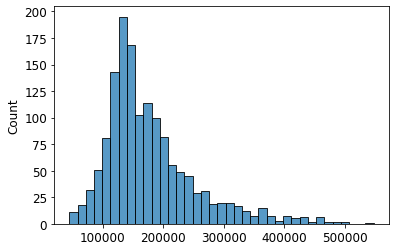

In [74]:
sns.histplot(test_preds_final)

In [75]:
output = pd.DataFrame({'Id': test.index,
                       'SalePrice': test_preds_final})
output.to_csv('submission_xgb9.csv', index=False)

# 6. Next Steps

1. With this version, leaderboard score = 0.12378, How to further improve the performance?
1. Understand the evaluation metric - RMSE of log SalePrice - how does that translate to error in actual SalePrice?
1. In general I need to build evaluation metric intuition.

# 7. References

- Fastai tabular Ideas: https://github.com/gautapb/fastbook/blob/master/09_tabular.ipynb
- Comprehensive EDA: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
- Ideas for improvement (not explored yet): https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1?scriptVersionId=20214677
- Partial dependence plots: https://www.kaggle.com/dansbecker/partial-dependence-plots